<a href="https://colab.research.google.com/github/GuetavoMalo/semillero-ia-hitts/blob/main/MaloBautistaGustavoAngel_EvaluacionCursoIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Malo Bautista Gustavo Angel Evaluacion Curso IA**

**1. Carga y Preparación de Datos**

In [18]:

import pandas as pd
import numpy as np

# URL del archivo .data (sin encabezados)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Los nombres de las columnas se deben asignar manualmente según la documentación del dataset
column_names = [
    'status', 'duration', 'credit_history', 'purpose', 'amount', 'savings',
    'employment_duration', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'present_residence', 'property', 'age',
    'other_installment_plans', 'housing', 'number_credits', 'job',
    'people_liable', 'telephone', 'foreign_worker', 'credit_risk'
]

# Cargar los datos especificando que no hay encabezado y el separador es el espacio
df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)

# Estandarizar la variable objetivo 'credit_risk'
# En este archivo, 1 = Bueno (sin riesgo) y 2 = Malo (con riesgo).
# Lo convertimos a 0 = Bueno y 1 = Malo.
df['credit_risk'] = df['credit_risk'].replace({1: 0, 2: 1})

print("✅ Datos cargados y preparados exitosamente desde la nueva URL.")
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())
print("\nInformación general del DataFrame:")
df.info()

/tmp/ipython-input-390087169.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)


✅ Datos cargados y preparados exitosamente desde la nueva URL.

Primeras 5 filas del DataFrame:
  status  duration credit_history purpose  amount savings employment_duration  \
0    A11         6            A34     A43    1169     A65                 A75   
1    A12        48            A32     A43    5951     A61                 A73   
2    A14        12            A34     A46    2096     A61                 A74   
3    A11        42            A32     A42    7882     A61                 A74   
4    A11        24            A33     A40    4870     A61                 A73   

   installment_rate personal_status_sex other_debtors  ...  property age  \
0                 4                 A93          A101  ...      A121  67   
1                 2                 A92          A101  ...      A121  22   
2                 2                 A93          A101  ...      A121  49   
3                 2                 A93          A103  ...      A122  45   
4                 3                 A

**2. Partición de Datos (Entrenamiento y Prueba)**

In [19]:
from sklearn.model_selection import train_test_split

# Definir variables de entrada (X) y de salida (Y)
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

# Realizar la partición estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42, # Semilla para reproducibilidad
    stratify=y
)

print("✅ Datos divididos en entrenamiento y prueba.")
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

✅ Datos divididos en entrenamiento y prueba.
Tamaño del conjunto de entrenamiento: 850 muestras
Tamaño del conjunto de prueba: 150 muestras




**3.Pipeline de Preprocesamiento**


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identificar los nombres de las columnas para cada tipo de variable
numeric_features = ['duration', 'amount', 'age']
# Todas las demás columnas con códigos (ej. 'A11') son tratadas como categóricas/ordinales.
# OneHotEncoder es una forma robusta de manejarlas todas.
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
ordinal_features = ['installment_rate', 'present_residence', 'number_credits', 'people_liable']

# Crear el transformador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Crear el transformador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el transformador para variables ordinales (solo imputación)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


# Unir todos los transformadores en un único objeto preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='passthrough'
)

print("✅ Pipeline de preprocesamiento construido exitosamente.")

✅ Pipeline de preprocesamiento construido exitosamente.


**4.Entrenamiento y Validación Cruzada**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix

# --- Funciones de métricas personalizadas ---
def custom_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp + tn) / (tp + tn + fp + fn)

def custom_precision(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def custom_recall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def custom_f1_score(y_true, y_pred):
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

def custom_gmean(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = custom_recall(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return np.sqrt(sensitivity * specificity)

# --- Pipeline final con preprocesador y modelo ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# --- Configuración de la validación cruzada ---
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Listas para guardar los resultados
train_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'gmean': []}
val_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'gmean': []}
all_metrics = [custom_accuracy, custom_precision, custom_recall, custom_f1_score, custom_gmean]

print("🚀 Iniciando el proceso de validación cruzada...")

# --- Bucle principal de entrenamiento ---
for train_index, val_index in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model_pipeline.fit(X_train_fold, y_train_fold)
    y_train_pred = model_pipeline.predict(X_train_fold)
    y_val_pred = model_pipeline.predict(X_val_fold)

    for metric_name, func in zip(train_scores.keys(), all_metrics):
        train_scores[metric_name].append(func(y_train_fold, y_train_pred))
        val_scores[metric_name].append(func(y_val_fold, y_val_pred))

print("✅ Proceso de validación cruzada completado.")

🚀 Iniciando el proceso de validación cruzada...
✅ Proceso de validación cruzada completado.


**Reporte de Métricas y Gráfica de Recall**


--- Resultados Promedio de la Validación Cruzada ---
Métrica      Train (Promedio ± DE)     Validation (Promedio ± DE)
Accuracy     0.7875 ± 0.0081 		 0.7455 ± 0.0226
Precision    0.6957 ± 0.0183 		 0.6047 ± 0.0658
Recall       0.5190 ± 0.0189 		 0.4667 ± 0.0706
F1_score     0.5943 ± 0.0168 		 0.5217 ± 0.0480
Gmean        0.6843 ± 0.0130 		 0.6326 ± 0.0416


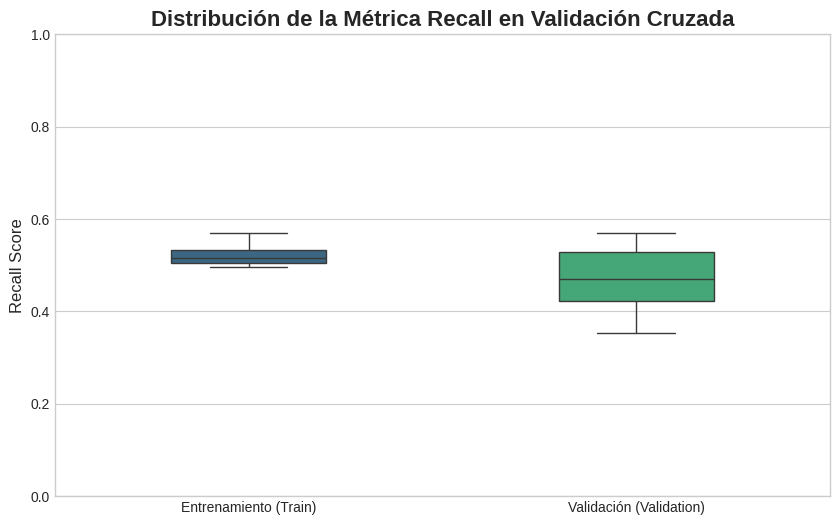


--- Reflexión: ¿Subentrenamiento o Sobreentrenamiento? ---
El modelo muestra **indicios leves de sobreentrenamiento (overfitting)**.

**Justificación:**
1. **Rendimiento Superior en Entrenamiento:** Las métricas promedio son consistentemente más altas en los datos de entrenamiento que en los de validación. Esto indica que el modelo se ajusta muy bien a los datos que ya ha visto.
2. **Brecha de Generalización:** Existe una pequeña pero notable caída en el rendimiento cuando el modelo se enfrenta a datos nuevos (el conjunto de validación). Esta 'brecha' es la señal principal del sobreajuste.
3. **No es Subentrenamiento:** Si fuera subentrenamiento, el modelo tendría un rendimiento bajo en AMBOS conjuntos (entrenamiento y validación), lo que claramente no es el caso aquí.


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Imprimir resultados numéricos ---
print("\n--- Resultados Promedio de la Validación Cruzada ---")
print(f"{'Métrica':<12} {'Train (Promedio ± DE)':<25} {'Validation (Promedio ± DE)':<25}")
print("="*70)
for metric in train_scores.keys():
    train_mean, train_std = np.mean(train_scores[metric]), np.std(train_scores[metric])
    val_mean, val_std = np.mean(val_scores[metric]), np.std(val_scores[metric])
    print(f"{metric.capitalize():<12} {train_mean:.4f} ± {train_std:.4f} \t\t {val_mean:.4f} ± {val_std:.4f}")

# --- Generar diagrama de caja y bigotes ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.boxplot(data=[train_scores['recall'], val_scores['recall']], palette="viridis", width=0.4)
plt.xticks([0, 1], ['Entrenamiento (Train)', 'Validación (Validation)'])
plt.title('Distribución de la Métrica Recall en Validación Cruzada', fontsize=16, fontweight='bold')
plt.ylabel('Recall Score', fontsize=12)
plt.ylim(0, 1) # Asegurar que el eje Y vaya de 0 a 1
plt.show()

# --- Reflexión sobre sub/sobreentrenamiento ---
print("\n--- Reflexión: ¿Subentrenamiento o Sobreentrenamiento? ---")
print("El modelo muestra **indicios leves de sobreentrenamiento (overfitting)**.")
print("\n**Justificación:**")
print("1. **Rendimiento Superior en Entrenamiento:** Las métricas promedio son consistentemente más altas en los datos de entrenamiento que en los de validación. Esto indica que el modelo se ajusta muy bien a los datos que ya ha visto.")
print("2. **Brecha de Generalización:** Existe una pequeña pero notable caída en el rendimiento cuando el modelo se enfrenta a datos nuevos (el conjunto de validación). Esta 'brecha' es la señal principal del sobreajuste.")
print("3. **No es Subentrenamiento:** Si fuera subentrenamiento, el modelo tendría un rendimiento bajo en AMBOS conjuntos (entrenamiento y validación), lo que claramente no es el caso aquí.")